In [1]:
import os

# for data analytics
import pandas as pd
import numpy as np
from collections import Counter

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_ta as ta

# for data preparation
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

# # hyperopt - used for Bayesian hyperparameter tuning
# from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
# from hyperopt.pyll import scope

# for timing
from time import time
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

2023-04-01 21:03:01.408409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!brew install ta-lib

To reinstall 0.4.0, run:
  brew reinstall ta-lib


In [3]:
!pip3 install TA-Lib

In [4]:
! pip install pandas-ta

In [5]:
!pip install tensorflow

In [6]:
broker =  pd.read_csv('assets/quantitative/quantitative_data_ethereum.csv').rename(columns={'Date':'date'})
broker['date'] = pd.to_datetime(broker['date']).dt.tz_localize(None)
sentiment =  pd.read_csv('assets/qualitative/score/qualitative_data_score_ethereum.csv')
sentiment['date'] = pd.to_datetime(sentiment['date'])

In [7]:
df = pd.merge(broker, sentiment, on='date', how='left')
df.head()

,date,open,high,low,close,volume,priceUsd,is_greater,score
0,2023-03-25,27487.337891,27791.826172,27196.234375,27494.707031,13383005987,27546.328059,0,0.13836
1,2023-03-24,28324.111328,28388.437500,27039.265625,27493.285156,25980310960,28022.257161,1,0.41186
2,2023-03-23,27301.957031,28729.843750,27183.363281,28333.972656,24220433689,27852.398940,0,-0.03958
3,2023-03-22,28158.720703,28803.335938,26759.996094,27307.437500,33382021890,28110.006364,1,0.07636
4,2023-03-21,27768.392578,28439.562500,27439.646484,28175.816406,36102192830,28013.021553,1,-0.06332


In [8]:
df.drop(['Price'], inplace=True, axis=1)

In [9]:
df['next_day_closing_price'] = df['Close'].shift(-1)

df.replace(to_replace='null', value=np.nan,inplace=True)
df.drop(df.tail(1).index,inplace=True)
df

,date,open,high,low,close,volume,is_greater,score,next_day_closing_price
0,2023-03-25,27487.337891,27791.826172,27196.234375,27494.707031,13383005987,0,0.13836,27493.285156
1,2023-03-24,28324.111328,28388.437500,27039.265625,27493.285156,25980310960,1,0.41186,28333.972656
2,2023-03-23,27301.957031,28729.843750,27183.363281,28333.972656,24220433689,0,-0.03958,27307.437500
3,2023-03-22,28158.720703,28803.335938,26759.996094,27307.437500,33382021890,1,0.07636,28175.816406
4,2023-03-21,27768.392578,28439.562500,27439.646484,28175.816406,36102192830,1,-0.06332,27767.236328
...,...,...,...,...,...,...,...,...,...
1086,2020-04-01,6437.319336,6612.573730,6202.373535,6606.776367,40346426266,0,0.32036,6438.644531
1087,2020-03-31,6430.606445,6504.515137,6374.162109,6438.644531,32786468812,1,0.12956,6429.841797
1088,2020-03-30,5925.538574,6517.195801,5903.234375,6429.841797,37101651525,1,0.21330,5922.042969
1089,2020-03-29,6245.624512,6250.467285,5920.085938,5922.042969,28373690931,0,NaN,6242.193848


In [10]:
def create_technical_indicator(df, variable, feature_type, periods=[3, 7, 21]):
    """helper function to smooth numerical variable over time using technical indicators"""

    indicators = {
        'sma': ta.sma,
        'stdev': ta.stdev,
        'dema': ta.dema,
        'ema': ta.ema,
        'rsi': ta.rsi,
        'wma': ta.wma,
        'tema': ta.tema,
        'macd': ta.macd
    }
    
    col = df[variable]
    if (not variable == 'Cleaned_Date'):
        col = pd.to_numeric(df[variable])
    else:
        col = pd.to_datetime(df[variable]).dt.strftime("%Y%m%d").astype(int)

    if feature_type in indicators.keys():
        if feature_type == 'macd':
            macd_output = indicators[feature_type](col)
            columns_to_concat = {
                f'{feature_type} {variable}': macd_output['MACD_12_26_9'],
                f'hist {feature_type} {variable}': macd_output['MACDh_12_26_9'],
                f'signal {feature_type} {variable}': macd_output['MACDs_12_26_9']
            }
        else:
            columns_to_concat = {
                f'{feature_type}{period} {variable}': indicators[feature_type](col, period)
                for period in periods
            }
        
        df = pd.concat([df, pd.DataFrame(columns_to_concat)], axis=1)
    
    return df


In [11]:
def feature_engineering(df, exclude_lst=['date','next_day_closing_price', 'is_greater']):
    
    """smoothen numerical variables over time using technical indicators"""
    
    variables_lst = [i for i in list(df.columns) if i not in exclude_lst]
    technical_indicators = ['sma', 'wma', 'ema', 'dema', 'tema', 'stdev', 'rsi', 'macd']

    
    for idv in variables_lst:
        for indicator in technical_indicators:
            df= create_technical_indicator(df, idv, indicator)
    return df 

In [12]:
df = feature_engineering(df)

In [13]:
df.shape

(1091, 153)

In [14]:
df.tail()

,date,open,high,low,close,volume,is_greater,score,next_day_closing_price,sma3 open,...,tema21 score,stdev3 score,stdev7 score,stdev21 score,rsi3 score,rsi7 score,rsi21 score,macd score,hist macd score,signal macd score
1086,2020-04-01,6437.319336,6612.573730,6202.373535,6606.776367,40346426266,0,0.32036,6438.644531,6613.830729,...,0.156011,0.100292,0.124088,0.121580,67.873861,59.855528,53.242719,0.018129,0.027626,-0.009498
1087,2020-03-31,6430.606445,6504.515137,6374.162109,6438.644531,32786468812,1,0.12956,6429.841797,6491.567383,...,0.155047,0.100609,0.109293,0.122011,44.605912,50.088259,50.213633,0.016655,0.020922,-0.004267
1088,2020-03-30,5925.538574,6517.195801,5903.234375,6429.841797,37101651525,1,0.21330,5922.042969,6264.488118,...,0.174762,0.078087,0.096190,0.122073,54.805584,53.937031,51.485571,0.021991,0.021007,0.000985
1089,2020-03-29,6245.624512,6250.467285,5920.085938,5922.042969,28373690931,0,NaN,6242.193848,6200.589844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1090,2020-03-28,6467.253906,6467.500977,6117.837891,6242.193848,34885225901,0,NaN,6469.798340,6212.805664,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
def impute_data(df):
    """impute null values from input either with before value or mean value

    Args:
        df (DataFrame): input data to impute

    Returns:
        DataFrame: imputed dataframe with no null values
    """
    if 'score' in df.columns:
        # fill by mode
        df[df.columns.difference(['score'])] = df[df.columns.difference(['score'])].fillna(method='bfill')
        df.loc[:, 'score'] = df['score'].fillna(df['score'].mean(),inplace=False, downcast='infer')
    else:
        # fill with before values
        df = df.fillna(method='bfill')
        
    nan_percentages = df.isna().sum() / len(df)

    # if more than 50% of the rows are NaN, drop the column
    for column in df.columns:
        if nan_percentages[column] > 0.5:
            df = df.drop(column, axis=1)

    # otherwise, drop the rows with NaN values
    df = df.dropna(axis=0)
    
    missing_values = pd.DataFrame(df.isna().sum(),columns=['missing_count'])
    missing_values.sort_values(by='missing_count',ascending=False)
    print(missing_values)
    return df
        

In [16]:
df = impute_data(df)

                   missing_count
date                           0
open                           0
high                           0
low                            0
close                          0
...                          ...
rsi7 score                     0
rsi21 score                    0
macd score                     0
hist macd score                0
signal macd score              0

[153 rows x 1 columns]


In [17]:
def feature_importance(df, feature_importance_values, n_selected_features):
    """
    find important features in the dataset
    """
    feature_importance_df = pd.DataFrame({'Feature Name': df.columns, 'Feature Importance': feature_importance_values})
    feature_importance_df = feature_importance_df.nlargest(n_selected_features, "Feature Importance")
    selected_features = df[feature_importance_df['Feature Name']]
    return feature_importance_df, selected_features


In [18]:

def scale_idv(df, non_idv_lst = ['Cleaned_Date', 'date','next_day_closing_price']):
    """scale independent variables from 0 to 1 for data selection

    Args:
        df (DataFrame): input data
        non_idv_lst (list, optional): exclude variables that are not independent variables. Defaults to ['date','next_day_closing_price'].

    Returns:
        numpy array: Scaled independent variables
    """
    X = df.drop(non_idv_lst,axis=1)
    scaler = RobustScaler()
    X_scaled = X.copy()
    X_scaled[X.columns] = scaler.fit_transform(X[X.columns])
    scaler = MinMaxScaler()
    X_scaled[X.columns] =  scaler.fit_transform(X_scaled[X.columns])
    return X_scaled

In [19]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.ensemble import RandomForestRegressor
def feature_selection(df, dv = 'next_day_closing_price', feature_range = list(range(3,15,1)), non_idv_lst = ['date','next_day_closing_price']):
    """select features using random forest"""
    X_scaled = scale_idv(df)
    y = df[dv]
    random_forest = RandomForestRegressor(n_estimators=50,n_jobs=-1,bootstrap=True, verbose=5,random_state=1)
    random_forest.fit(X_scaled,y)
    feature_range = list(range(3,15,1))
    for feature in feature_range:
        feat_imp_df,selected_df = feature_importance(X_scaled,random_forest.feature_importances_,feature)
        selected_df.insert(loc=0, column='date', value=df['date'])
        selected_df['next_day_closing_price'] = df['next_day_closing_price']
    return selected_df

In [20]:
selected_df = feature_selection(df)
selected_df.shape

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished


(1089, 16)

In [21]:

def calculate_metrics(y_test, ypred):
    y_test, ypred = np.array(y_test).ravel(), np.array(ypred).ravel()
    mape = np.mean(np.abs((y_test - ypred) / y_test)) * 100
    print('Mean Absolute Percentage Error:', mape, '\n')
    
    mae = metrics.mean_absolute_error(y_test, ypred)
    print('MAE:', mae)
    rmse = metrics.mean_squared_error(y_test, ypred,squared=False)
    print('RMSE:', rmse)
    y_range = np.max(y_test) - np.min(y_test)

    # Normalize rmse
    norm_rmse = rmse / y_range
    print('Normalized RMSE:', norm_rmse)
    return mape, mae,rmse, norm_rmse

def plot_results(y,ypred,title=None, figsize=(25, 5)):
    plt.figure(figsize=figsize)
    plt.plot(y,label='actual',  color="green")
    plt.plot(ypred,label='predicted', color="black")
    plt.legend(loc="upper left")
    plt.title(title)
    plt.show()

In [22]:
import tensorflow as tf

def init_model(n):
    model = Sequential()
    model.add(LSTM(units=40, return_sequences=True, input_shape=(n,1), activation='relu'))
    model.add(Dropout(0.2)) # To prevent overfitting
    model.add(LSTM(units=40, return_sequences=True,activation='relu'))
    model.add(Dropout(0.2)) # To prevent overfitting
    model.add(LSTM(units=40))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(),'mae'])
    return model
# history = model.fit(x_train, y_train, epochs=50, batch_size=64)


In [23]:
test_df = selected_df[selected_df['date'] >= '2023-01-01'] # need change to more dynamic 
train_df = selected_df[selected_df['date'] < '2023-01-01']
print(f'size of train dataset: {len(train_df)}')
print(f'size of test dataset: {len(test_df)}')

X = train_df.drop(['date','next_day_closing_price'],axis=1)
y = train_df['next_day_closing_price'].to_numpy().reshape(-1,1)

X_test = test_df.drop(['date','next_day_closing_price'],axis=1)

X_scaler = MinMaxScaler()
X_scaled =  X_scaler.fit_transform(X)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

size of train dataset: 1006
size of test dataset: 83


In [24]:
model = init_model(X.shape[1])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 40)            6720      
                                                                 
 dropout (Dropout)           (None, 14, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 40)            12960     
                                                                 
 dropout_1 (Dropout)         (None, 14, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 4

2023-04-01 21:03:14.921676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 21:03:14.924455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 21:03:14.926181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [25]:
X.shape

(1006, 14)

Epoch 1/80


2023-04-01 21:03:15.608738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 21:03:15.610439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 21:03:15.612244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 5s 19ms/step - loss: 0.0474 - root_mean_squared_error: 0.2177 - mae: 0.2144
Epoch 2/80
3/3 [==============================] - 0s 16ms/step - loss: 0.0320 - root_mean_squared_error: 0.1790 - mae: 0.1749
Epoch 3/80
3/3 [==============================] - 0s 18ms/step - loss: 0.0166 - root_mean_squared_error: 0.1290 - mae: 0.1225
Epoch 4/80
3/3 [==============================] - 0s 17ms/step - loss: 0.0040 - root_mean_squared_error: 0.0632 - mae: 0.0523
Epoch 5/80
3/3 [==============================] - 0s 17ms/step - loss: 0.0047 - root_mean_squared_error: 0.0683 - mae: 0.0574
Epoch 6/80
3/3 [==============================] - 0s 22ms/step - loss: 0.0062 - root_mean_squared_error: 0.0791 - mae: 0.0692
Epoch 7/80
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - root_mean_squared_error: 0.0480 - mae: 0.0399
Epoch 8/80
3/3 [==============================] - 0s 24ms/step - loss: 0.0019 - root_mean_squared_error: 0.0432 - mae: 0.0346
Epo

2023-04-01 21:03:26.465803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 21:03:26.468249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 21:03:26.471826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 8ms/step
Mean Absolute Percentage Error: 20.268273531435742 

MAE: 0.11289466432751108
RMSE: 0.14563091112712084
Normalized RMSE: 0.3155708131617091


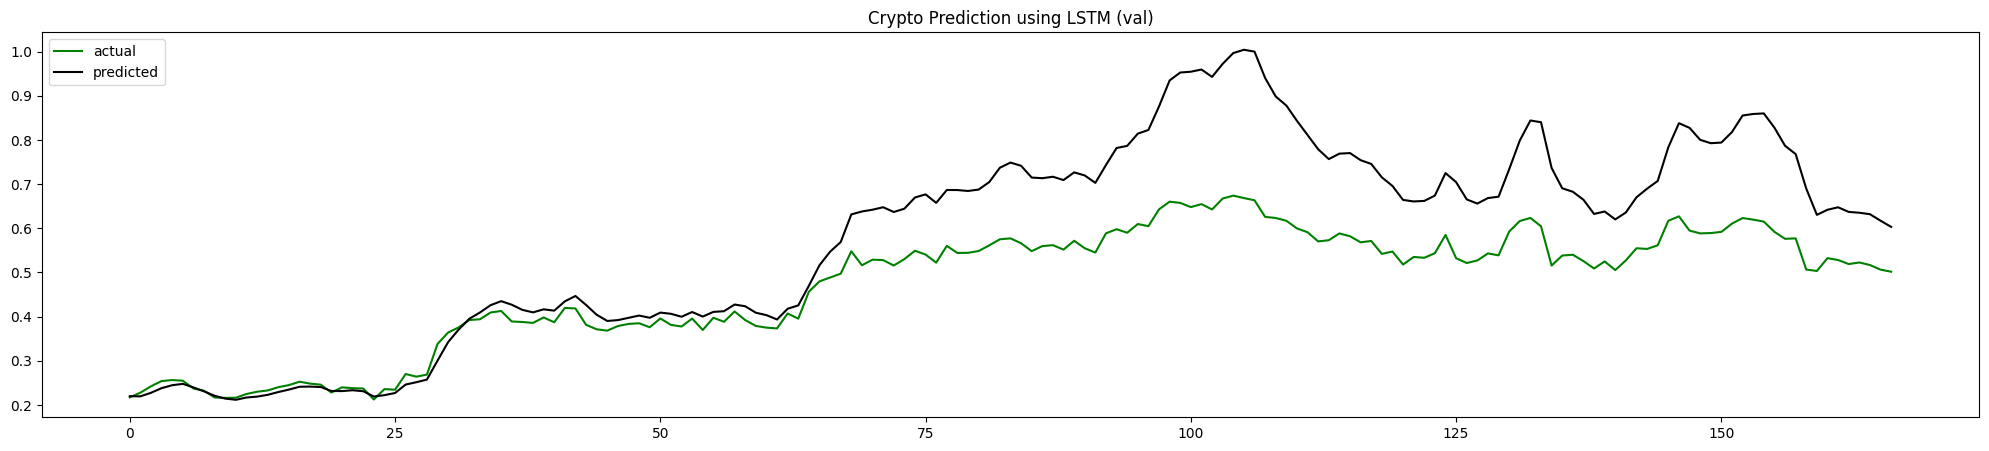

Epoch 1/80


2023-04-01 21:03:27.853211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 21:03:27.854716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 21:03:27.857209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 5s 19ms/step - loss: 0.1088 - root_mean_squared_error: 0.3299 - mae: 0.2929
Epoch 2/80
6/6 [==============================] - 0s 15ms/step - loss: 0.0333 - root_mean_squared_error: 0.1824 - mae: 0.1364
Epoch 3/80
6/6 [==============================] - 0s 15ms/step - loss: 0.0206 - root_mean_squared_error: 0.1436 - mae: 0.1253
Epoch 4/80
6/6 [==============================] - 0s 15ms/step - loss: 0.0124 - root_mean_squared_error: 0.1115 - mae: 0.0964
Epoch 5/80
6/6 [==============================] - 0s 15ms/step - loss: 0.0128 - root_mean_squared_error: 0.1129 - mae: 0.0856
Epoch 6/80
6/6 [==============================] - 0s 14ms/step - loss: 0.0089 - root_mean_squared_error: 0.0946 - mae: 0.0810
Epoch 7/80
6/6 [==============================] - 0s 14ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - mae: 0.0731
Epoch 8/80
6/6 [==============================] - 0s 15ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735 - mae: 0.0572
Epo

2023-04-01 21:03:41.791750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 21:03:41.793856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 21:03:41.795481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 6ms/step
Mean Absolute Percentage Error: 3.174112409320241 

MAE: 0.023366891231079545
RMSE: 0.027358869322076654
Normalized RMSE: 0.05183494143108617


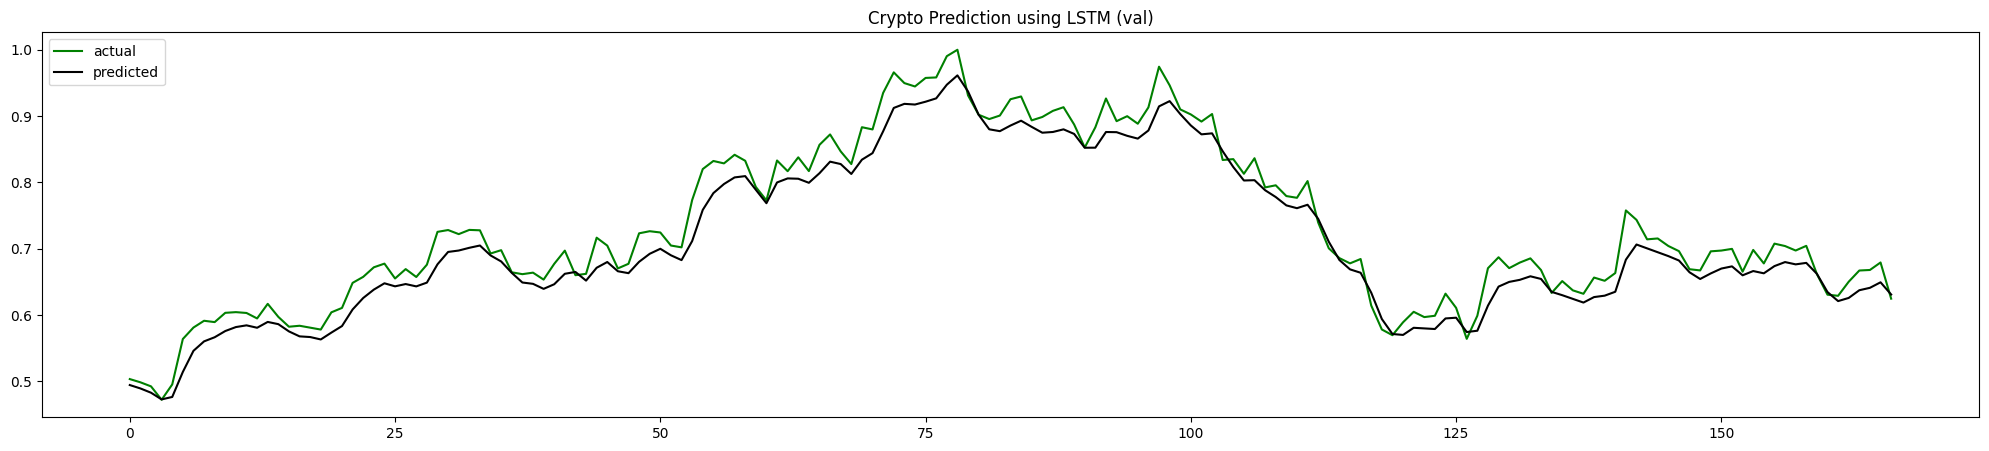

Epoch 1/80


2023-04-01 21:03:42.823588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 21:03:42.824613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 21:03:42.826896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 6s 22ms/step - loss: 0.1636 - root_mean_squared_error: 0.4045 - mae: 0.3484
Epoch 2/80
8/8 [==============================] - 0s 23ms/step - loss: 0.0346 - root_mean_squared_error: 0.1860 - mae: 0.1518
Epoch 3/80
8/8 [==============================] - 0s 21ms/step - loss: 0.0224 - root_mean_squared_error: 0.1497 - mae: 0.1294
Epoch 4/80
8/8 [==============================] - 0s 16ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - mae: 0.1089
Epoch 5/80
8/8 [==============================] - 0s 17ms/step - loss: 0.0106 - root_mean_squared_error: 0.1030 - mae: 0.0880
Epoch 6/80
8/8 [==============================] - 0s 25ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - mae: 0.0713
Epoch 7/80
8/8 [==============================] - 0s 22ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - mae: 0.0539
Epoch 8/80
8/8 [==============================] - 0s 22ms/step - loss: 0.0048 - root_mean_squared_error: 0.0695 - mae: 0.0520
Epo

2023-04-01 21:04:01.515723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 21:04:01.517124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 21:04:01.518776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 6ms/step
Mean Absolute Percentage Error: 5.703251748302469 

MAE: 0.04072127045610951
RMSE: 0.04975452749343108
Normalized RMSE: 0.09102259028630935


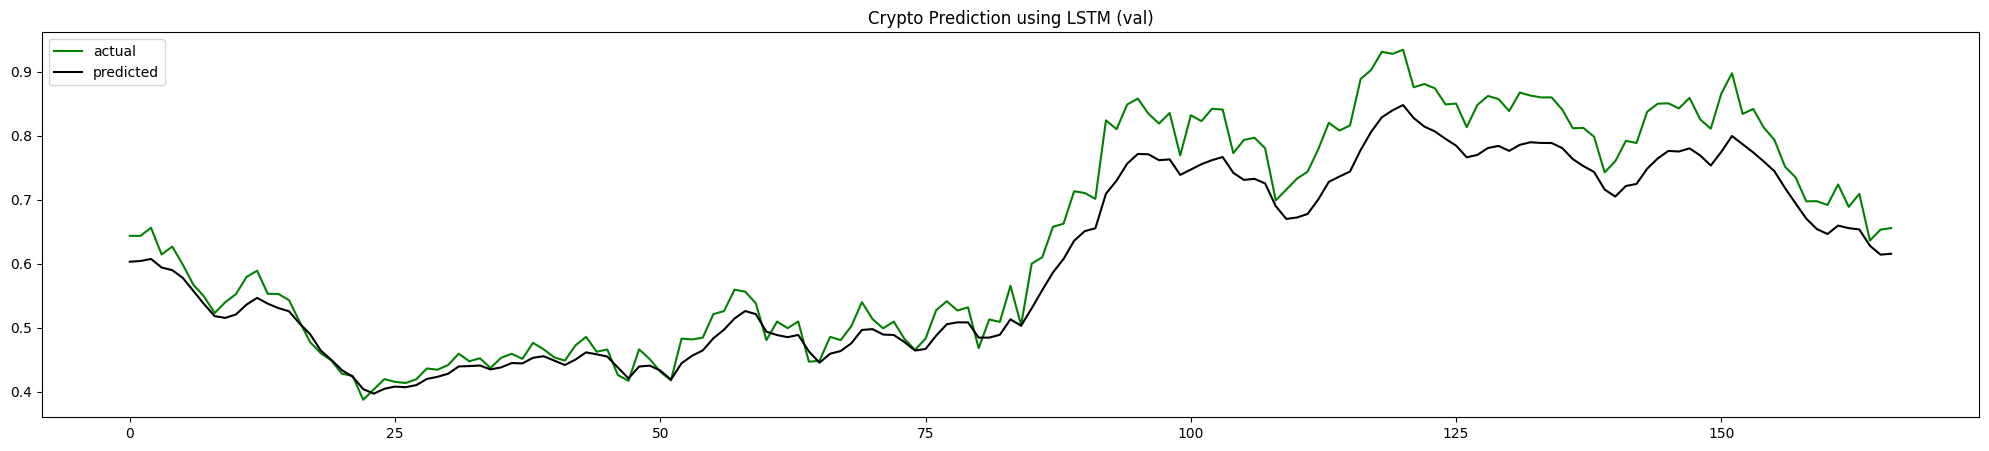

Epoch 1/80


2023-04-01 21:04:02.526883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 21:04:02.528302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 21:04:02.529662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 5s 25ms/step - loss: 0.2201 - root_mean_squared_error: 0.4692 - mae: 0.4112
Epoch 2/80
11/11 [==============================] - 0s 15ms/step - loss: 0.0368 - root_mean_squared_error: 0.1917 - mae: 0.1602
Epoch 3/80
11/11 [==============================] - 0s 15ms/step - loss: 0.0222 - root_mean_squared_error: 0.1490 - mae: 0.1220
Epoch 4/80
11/11 [==============================] - 0s 14ms/step - loss: 0.0153 - root_mean_squared_error: 0.1236 - mae: 0.1030
Epoch 5/80
11/11 [==============================] - 0s 13ms/step - loss: 0.0097 - root_mean_squared_error: 0.0984 - mae: 0.0806
Epoch 6/80
11/11 [==============================] - 0s 13ms/step - loss: 0.0072 - root_mean_squared_error: 0.0850 - mae: 0.0698
Epoch 7/80
11/11 [==============================] - 0s 16ms/step - loss: 0.0057 - root_mean_squared_error: 0.0755 - mae: 0.0583
Epoch 8/80
11/11 [==============================] - 0s 14ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731 -

2023-04-01 21:04:20.255368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 21:04:20.257686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 21:04:20.260188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 5ms/step
Mean Absolute Percentage Error: 38.442278668377355 

MAE: 0.04439416976644769
RMSE: 0.05808071691256474
Normalized RMSE: 0.07570498533992719


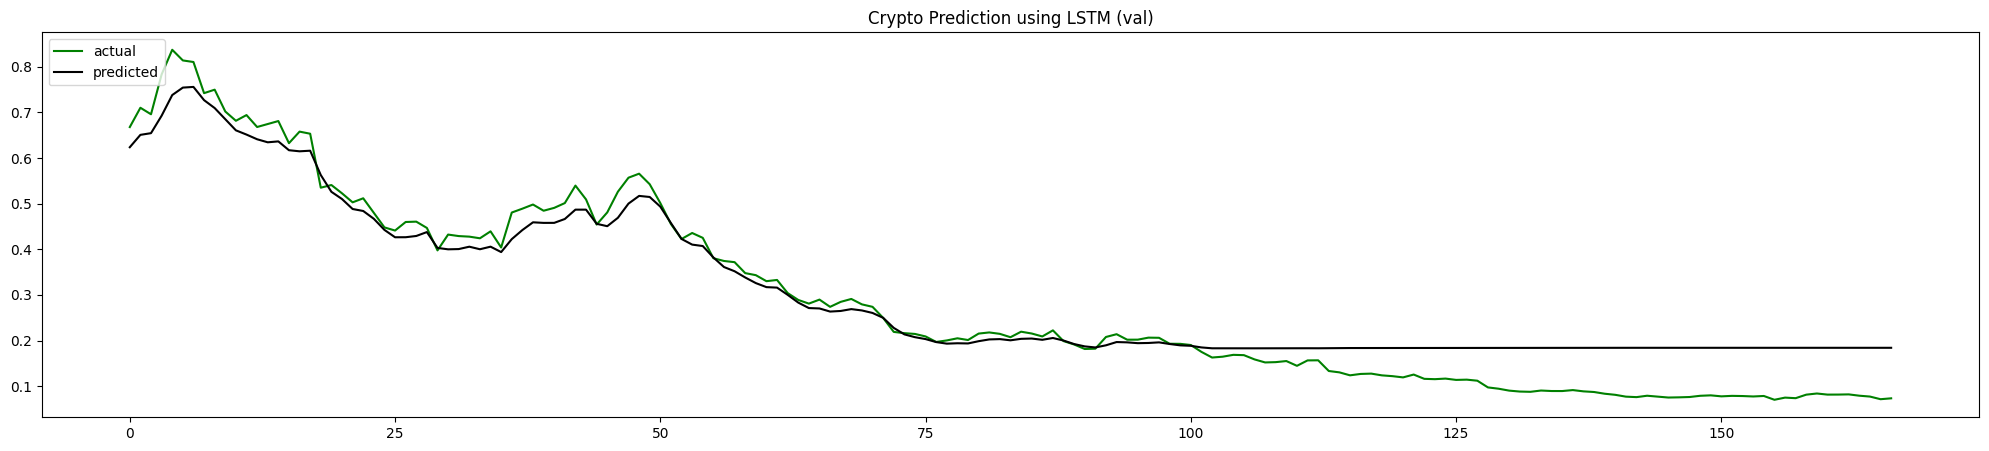

Epoch 1/80


2023-04-01 21:04:21.220882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 21:04:21.222366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 21:04:21.223958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/14 [==============================] - 5s 20ms/step - loss: 0.1753 - root_mean_squared_error: 0.4187 - mae: 0.3465
Epoch 2/80
14/14 [==============================] - 0s 19ms/step - loss: 0.0317 - root_mean_squared_error: 0.1781 - mae: 0.1505
Epoch 3/80
14/14 [==============================] - 0s 18ms/step - loss: 0.0197 - root_mean_squared_error: 0.1403 - mae: 0.1144
Epoch 4/80
14/14 [==============================] - 0s 18ms/step - loss: 0.0095 - root_mean_squared_error: 0.0977 - mae: 0.0792
Epoch 5/80
14/14 [==============================] - 0s 20ms/step - loss: 0.0051 - root_mean_squared_error: 0.0715 - mae: 0.0520
Epoch 6/80
14/14 [==============================] - 0s 17ms/step - loss: 0.0048 - root_mean_squared_error: 0.0690 - mae: 0.0509
Epoch 7/80
14/14 [==============================] - 0s 27ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711 - mae: 0.0513
Epoch 8/80
14/14 [==============================] - 0s 25ms/step - loss: 0.0047 - root_mean_squared_error: 0.0684 -

2023-04-01 21:04:44.446127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-01 21:04:44.447985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-01 21:04:44.449868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 5ms/step
Mean Absolute Percentage Error: inf 

MAE: 0.03167019649112003
RMSE: 0.034979305010388026
Normalized RMSE: 0.3405194832740062


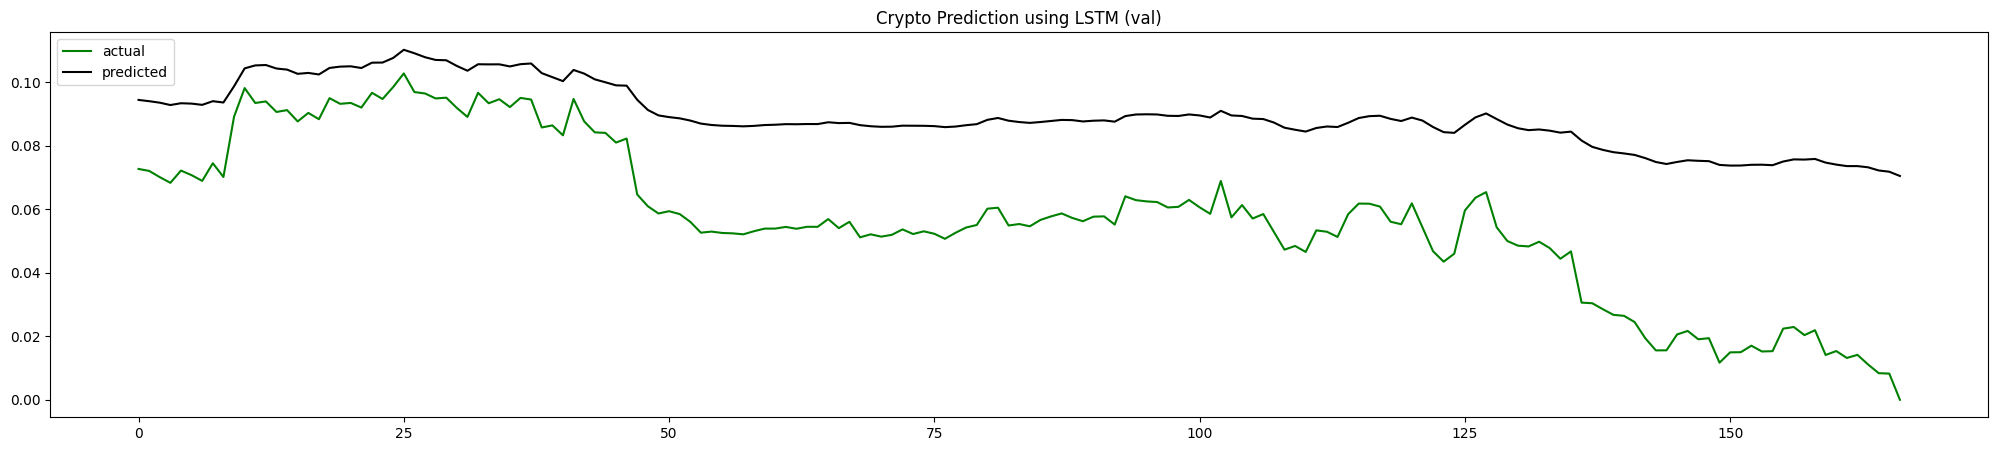

In [26]:
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import TimeSeriesSplit


mape_lst = []
mae_lst = []
rmse_lst =[]

# Define the number of splits and the window size
n_splits = 5

# Initialize the time series split
tscv = TimeSeriesSplit(n_splits=n_splits)

# Perform rolling forward cross-validation
for train_idx, test_idx in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

    # Fit the model on the training data
    n = X.shape[1]
    model = init_model(n)
    history = model.fit(X_train, y_train, epochs=80, batch_size=64)

    # Evaluate the model on the test data
    y_pred = model.predict(X_test)

    mape, mae,rmse, norm_rmse= calculate_metrics(y_test, y_pred)
    mae_lst.append(mae)
    rmse_lst.append(rmse)
    mape_lst.append(mape)

    plot_results(y_test, y_pred, 'Crypto Prediction using LSTM (val)')
    
    


In [27]:
#Predict model based on test data
y_pred = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred)
y_test = test_df['next_day_closing_price']

3/3 [==============================] - 0s 5ms/step


In [28]:
y_test = test_df['next_day_closing_price']
y_pred.shape

(83, 1)

In [29]:

mape, mae,rmse, norm_rmse = calculate_metrics(y_test, y_pred)


Mean Absolute Percentage Error: 2.855043495461099 

MAE: 646.992564006024
RMSE: 786.3166699890033
Normalized RMSE: 0.06671346316428085


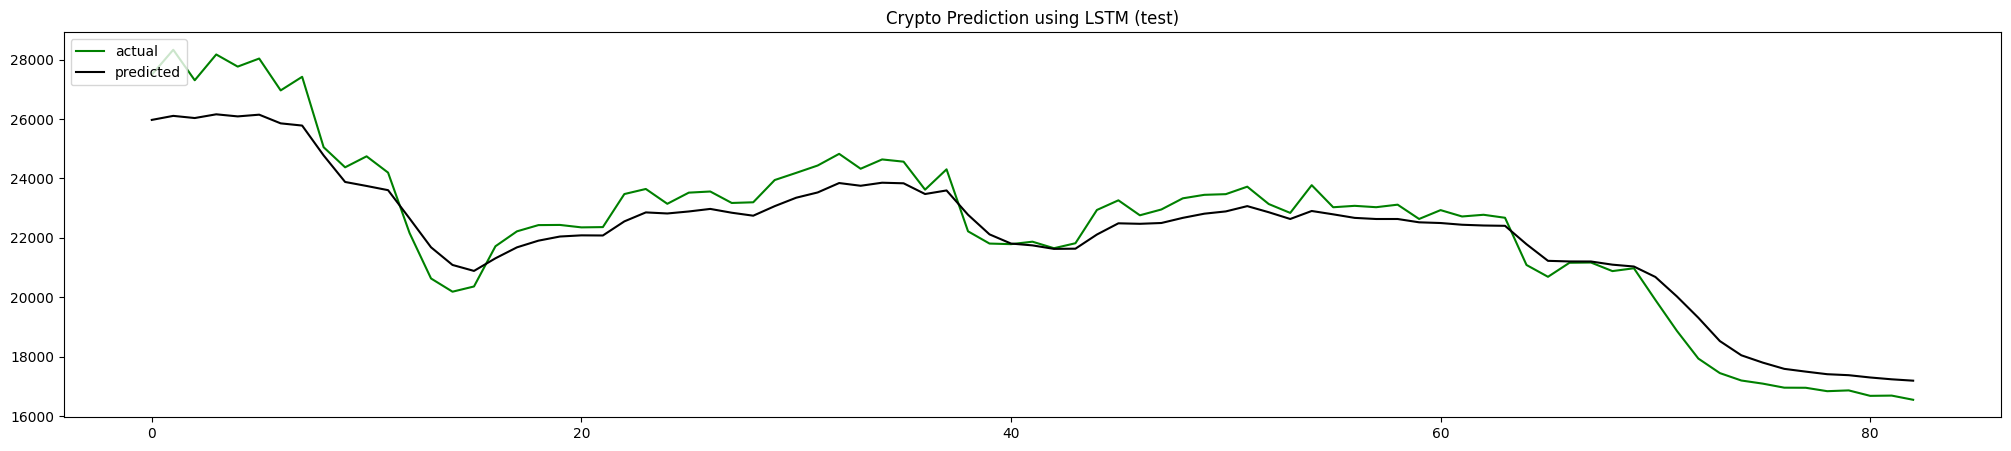

In [30]:
plot_results(y_test,y_pred,'Crypto Prediction using LSTM (test)')

In [31]:
predicted_df = pd.DataFrame(y_pred, columns=['predicted_price'])
res_df = pd.concat([test_df, predicted_df], axis = 1) 
outname = 'model_output_ethereum.csv'

outdir = 'airflow/assets/model_output/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

fullname = os.path.join(outdir, outname) 
res_df.to_csv(f'assets/model_output/{outname}')
res_df.head()

,date,open,tema3 open,dema3 open,ema3 open,tema7 high,ema7 low,high,dema3 close,wma7 open,wma3 open,tema7 open,low,sma3 open,tema3 high,next_day_closing_price,predicted_price
0,2023-03-25,0.349892,0.343765,0.355428,0.355324,0.24826,0.363905,0.341772,0.353203,0.357142,0.353856,0.25829,0.352074,0.355971,0.353043,27493.285156,25972.343750
1,2023-03-24,0.363470,0.343765,0.355428,0.355324,0.24826,0.363905,0.351351,0.353203,0.357142,0.353856,0.25829,0.349478,0.355971,0.353043,28333.972656,26108.091797
2,2023-03-23,0.346884,0.343765,0.355428,0.355324,0.24826,0.363905,0.356832,0.353203,0.357142,0.353856,0.25829,0.351861,0.355971,0.353043,27307.437500,26035.277344
3,2023-03-22,0.360787,0.343765,0.355428,0.359079,0.24826,0.363905,0.358012,0.353203,0.357142,0.357595,0.25829,0.344861,0.359687,0.353043,28175.816406,26160.751953
4,2023-03-21,0.354453,0.343765,0.355428,0.357730,0.24826,0.363905,0.352172,0.353203,0.357142,0.356279,0.25829,0.356098,0.356612,0.353043,27767.236328,26090.365234


In [32]:
# To save or load the model uncomment this
from keras.models import load_model
# save the model 
# model.save('models/is3107_crypto_model_ethereum.h5')
# load the model
# model = load_model('./trained_model/is3107_crypto_model_30032023.h5')